<a href="https://colab.research.google.com/github/Dimisz/pytorch/blob/main/image_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Utility Functions

In [3]:
def get_image(path, img_transform, size=(300,300)):
  image = Image.open(path)
  image = image.resize(size, Image.LANCZOS)
  image = img_transform(image).unsqueeze(0)
  return image.to(device)

In [4]:
def get_gram(m):
  """
  m is of shape (1, C, H, W)
  """
  _, c, h, w = m.size()
  m = m.view(c, h * w)
  m = torch.mm(m, m.t())
  return m

In [5]:
def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [6]:
# def denormalize_img(inp):
#   inp = inp.numpy().transpose((1,2,0)) # C,H,W --> (H,W,C)
#   mean = np.array([0.485, 0.456, 0.406])
#   std = np.array([0.229, 0.224, 0.225])
#   inp = inp * std + mean
#   inp = inp.clip(inp, 0, 1)
#   return inp

## Constructing a model

In [7]:
class FeaturesExtractor(nn.Module):
  def __init__(self):
    super(FeaturesExtractor,self).__init__()
    self.selected_layers = [3,8,15,22]
    self.vgg = models.vgg16(pretrained=True).features
  def forward(self, x):
    layer_features = []
    for layer_number, layer in self.vgg._modules.items():
      x = layer(x)
      if int(layer_number) in self.selected_layers:
        layer_features.append(x)
    return layer_features

In [8]:
import torch.optim as optim

In [10]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
content_img = get_image("/content/simpsons.jpg",
                        img_transform)
style_img = get_image("/content/lake.jpg",
                      img_transform)
generated_img = content_img.clone()
generated_img.requires_grad = True

optimizer = optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeaturesExtractor().to(device)

for p in encoder.parameters():
  p.requires__grad = False


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
style_weight = 100
content_weight = 1

for epoch in range(500):

  content_features = encoder(content_img)
  style_features = encoder(style_img)
  generated_features = encoder(generated_img)

  content_loss = (torch.mean(content_features[-1] - generated_features[-1])**2)
  style_loss = 0
  for gf, sf in zip(generated_features, style_features):
    _, c, h, w = gf.size()
    gram_gf = get_gram(gf)
    gram_sf = get_gram(sf)
    style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w)
  
  loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if epoch % 10 == 0:
    print("Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}".format(epoch, content_loss.item(), style_loss.item()))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0]	Content Loss: 0.0000	Style Loss: 3459.2136
Epoch [10]	Content Loss: 0.0028	Style Loss: 2530.9360
Epoch [20]	Content Loss: 0.0053	Style Loss: 1979.2247
Epoch [30]	Content Loss: 0.0067	Style Loss: 1619.5636
Epoch [40]	Content Loss: 0.0074	Style Loss: 1364.4531
Epoch [50]	Content Loss: 0.0078	Style Loss: 1173.5508
Epoch [60]	Content Loss: 0.0080	Style Loss: 1024.9391
Epoch [70]	Content Loss: 0.0082	Style Loss: 906.4233
Epoch [80]	Content Loss: 0.0083	Style Loss: 809.7940
Epoch [90]	Content Loss: 0.0084	Style Loss: 729.5981
Epoch [100]	Content Loss: 0.0084	Style Loss: 661.9011
Epoch [110]	Content Loss: 0.0083	Style Loss: 603.5857
Epoch [120]	Content Loss: 0.0081	Style Loss: 552.8135
Epoch [130]	Content Loss: 0.0080	Style Loss: 508.5750
Epoch [140]	Content Loss: 0.0078	Style Loss: 469.9231
Epoch [150]	Content Loss: 0.0076	Style Loss: 435.7950
Epoch [160]	Content Loss: 0.0075	Style Loss: 405.4166
Epoch [170]	Content Loss: 0.0074	Style Loss: 378.2492
Epoch [180]	Content Loss: 0.0072

In [12]:
inp = generated_img.detach().cpu().squeeze()

In [13]:
inp.shape

torch.Size([3, 300, 300])

In [14]:
inp = denormalize_img(inp)

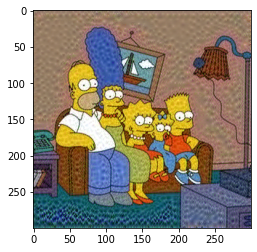

In [15]:
plt.imshow(inp)